## VAE

### setup

In [1]:
import argparse

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
import mnist

<module 'mnist' from '/home/fehiepsi/Projects/pytorch-notebooks/executable/mnist.py'>

In [5]:
parser = {
    'data_path': '../data/mnist/'
    'epochs': 10,
    'batch_size': 128,
    "cuda": True,
    "seed": 7,
    "worker": 4,
    "log_interval": 10
}
args = argparse.Namespace(**parser)

args.cuda = args.cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

### model

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400) # image size = 28x28
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if args.cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3)) # sigmoid force output in (0,1)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

### train

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

In [13]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if args.cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [14]:
def test(epoch):
    model.eval()
    test_loss = 0
    for data, _ in test_loader:
        if args.cuda:
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

### prepare

In [ ]:
train_loader = DataLoader(
    mnist.MNIST(args.data_path, train=True, download=True,
                transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
test_loader = DataLoader(
    mnist.MNIST(args.data_path, train=False,
                transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

In [9]:
model = VAE()
reconstruction_function = nn.BCELoss()
if args.cuda:
    model.cuda()
    reconstruction_function.cuda()

In [12]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### train

In [15]:
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 549.163147
Train Epoch: 1 [1280/60000 (2%)]	Loss: 310.190155
Train Epoch: 1 [2560/60000 (4%)]	Loss: 237.475967
Train Epoch: 1 [3840/60000 (6%)]	Loss: 218.875137
Train Epoch: 1 [5120/60000 (9%)]	Loss: 220.173553
Train Epoch: 1 [6400/60000 (11%)]	Loss: 208.233978
Train Epoch: 1 [7680/60000 (13%)]	Loss: 206.940262
Train Epoch: 1 [8960/60000 (15%)]	Loss: 195.648148
Train Epoch: 1 [10240/60000 (17%)]	Loss: 192.501144
Train Epoch: 1 [11520/60000 (19%)]	Loss: 189.642365
Train Epoch: 1 [12800/60000 (21%)]	Loss: 182.816895
Train Epoch: 1 [14080/60000 (23%)]	Loss: 170.538513
Train Epoch: 1 [15360/60000 (26%)]	Loss: 169.197968
Train Epoch: 1 [16640/60000 (28%)]	Loss: 163.083633
Train Epoch: 1 [17920/60000 (30%)]	Loss: 168.747955
Train Epoch: 1 [19200/60000 (32%)]	Loss: 167.840469
Train Epoch: 1 [20480/60000 (34%)]	Loss: 160.396820
Train Epoch: 1 [21760/60000 (36%)]	Loss: 162.171478
Train Epoch: 1 [23040/60000 (38%)]	Loss: 153.103333
Train Epoch: 1 [24320/60000 

### generate

In [21]:
data, _ = iter(test_loader).next()

In [22]:
if args.cuda:
    data = data.cuda()

data = Variable(data, volatile=True)
recon_batch, mu, logvar = model(data)
recon = recon_batch.view(-1, 1, 28, 28)

In [23]:
sample = data.data[0, 0].cpu().numpy()
recon_sample = recon.data[0,0].cpu().numpy()

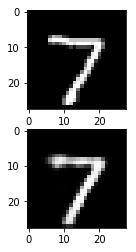

In [24]:
plt.subplot(211)
plt.imshow(sample, vmin=0, vmax=1, cmap="gray")
plt.subplot(212)
plt.imshow(recon_sample, vmin=0, vmax=1, cmap="gray")

## Conditional VAE

In [1]:
import os
import importlib
import argparse

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.core.debugger import Tracer; debug_here = Tracer()

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchnet.meter import AverageValueMeter

In [3]:
import mnist; importlib.reload(mnist)

<module 'mnist' from '/home/fehiepsi/Projects/pytorch-notebooks/executable/mnist.py'>

In [5]:
intermediate_path = os.path.join("..", "intermediate", "vae")
if not os.path.exists(intermediate_path):
    os.makedirs(intermediate_path)

In [6]:
mb_size = 64
epochs = 100
Z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128 # number of hidden unit
lr = 1e-3

In [7]:
torch.manual_seed(7)

In [8]:
train_loader = DataLoader(
    mnist.MNIST('../data', train=True, download=True,
                transform=transforms.ToTensor()),
    batch_size=mb_size, shuffle=True)
test_loader = DataLoader(
    mnist.MNIST('../data', train=False,
                transform=transforms.ToTensor()),
    batch_size=mb_size, shuffle=False)

In [9]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [10]:
Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

In [11]:
Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

In [12]:
Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

In [13]:
def Q(X, c):
    inputs = torch.cat([X, c], 1)
    h = F.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_logvar = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_logvar

In [14]:
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mu.size(0), Z_dim))
    return mu + torch.exp(log_var / 2) * eps

In [15]:
Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

In [16]:
def P(z, c):
    inputs = torch.cat([z, c], 1)
    h = F.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = F.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [17]:
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)

In [18]:
def train(epoch):
    losses = AverageValueMeter()
    
    for i, (X, c) in enumerate(train_loader):
        X = X.view(-1, 784)
        c_onehot = torch.zeros(c.size(0), y_dim).scatter_(1, c.unsqueeze(1), 1)
        X = Variable(X)
        c_onehot = Variable(c_onehot)

        # Forward
        z_mu, z_logvar = Q(X, c_onehot)
        z = sample_z(z_mu, z_logvar)
        X_sample = P(z, c_onehot)

        # Loss
        recon_loss = F.binary_cross_entropy(X_sample, X, size_average=False)
        kl_loss = 0.5 * torch.sum(torch.exp(z_logvar) + z_mu**2 - 1 - z_logvar)
        loss = recon_loss + kl_loss
        
        # Backward
        for p in params:
            p.grad.data.zero_()
        loss.backward()
        solver.step()
        
        losses.add(loss.data[0], X.size(0))
    
    print("Epoch: {0}/{1}\tLoss: {2:.4f}"
          .format(epoch, epochs, losses.value()[0]))

In [19]:
def plot(samples, epoch):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(sample.reshape(28, 28), cmap="Greys_r")

    out_path = os.path.join(intermediate_path, "out")
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    out_filepath = os.path.join(out_path, 
                                "{}.png".format(str(epoch).zfill(3)))
    plt.savefig(out_filepath, bbox_inches='tight')
    plt.close(fig)

In [20]:
for epoch in range(1, epochs+1):
    train(epoch)
    c = torch.from_numpy(np.random.randint(0, 10, mb_size))
    c_onehot = torch.zeros(c.size(0), y_dim).scatter_(1, c.unsqueeze(1), 1)
    z = torch.randn(mb_size, Z_dim)
    samples = P(Variable(z), Variable(c_onehot)).data.numpy()[:16]
    plot(samples, epoch)

Epoch: 1/100	Loss: 183.9763
Epoch: 2/100	Loss: 135.6942
Epoch: 3/100	Loss: 123.3090
Epoch: 4/100	Loss: 116.8960
Epoch: 5/100	Loss: 113.2857
Epoch: 6/100	Loss: 111.1799
Epoch: 7/100	Loss: 109.7620
Epoch: 8/100	Loss: 108.6592
Epoch: 9/100	Loss: 107.9670
Epoch: 10/100	Loss: 107.3998
Epoch: 11/100	Loss: 106.8704
Epoch: 12/100	Loss: 106.4485
Epoch: 13/100	Loss: 106.1208
Epoch: 14/100	Loss: 105.8686
Epoch: 15/100	Loss: 105.6030
Epoch: 16/100	Loss: 105.3722
Epoch: 17/100	Loss: 105.1703
Epoch: 18/100	Loss: 104.9846
Epoch: 19/100	Loss: 104.8853
Epoch: 20/100	Loss: 104.6661
Epoch: 21/100	Loss: 104.5560
Epoch: 22/100	Loss: 104.4186
Epoch: 23/100	Loss: 104.2742
Epoch: 24/100	Loss: 104.2110
Epoch: 25/100	Loss: 104.0873
Epoch: 26/100	Loss: 103.9460
Epoch: 27/100	Loss: 103.8903
Epoch: 28/100	Loss: 103.7722
Epoch: 29/100	Loss: 103.7146
Epoch: 30/100	Loss: 103.6487
Epoch: 31/100	Loss: 103.5393
Epoch: 32/100	Loss: 103.4941
Epoch: 33/100	Loss: 103.3744
Epoch: 34/100	Loss: 103.3083
Epoch: 35/100	Loss: 103

## Denoising VAE

In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchnet.meter import AverageValueMeter

In [4]:
import mnist

In [5]:
intermediate_path = os.path.join("..", "intermediate", "dvae")
if not os.path.exists(intermediate_path):
    os.makedirs(intermediate_path)

In [7]:
mb_size = 64
epochs = 100
Z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128 # number of hidden unit
lr = 1e-3
noise_factor = .25

In [8]:
torch.manual_seed(7)

In [9]:
train_loader = DataLoader(
    mnist.MNIST('../data', train=True, download=True,
                transform=transforms.ToTensor()),
    batch_size=mb_size, shuffle=True)
test_loader = DataLoader(
    mnist.MNIST('../data', train=False,
                transform=transforms.ToTensor()),
    batch_size=mb_size, shuffle=False)

In [10]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [11]:
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

In [12]:
def Q(X):
    h = F.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_var = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_var

def sample_z(mu, log_var):
    eps = Variable(torch.randn(mu.size(0), Z_dim))
    return mu + torch.exp(log_var / 2) * eps

In [13]:
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

In [14]:
def P(z):
    h = F.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = F.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [15]:
""" Training """
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

solver = optim.Adam(params, lr=lr)

In [16]:
def train(epoch):
    losses = AverageValueMeter()
    
    for i, (X, _) in enumerate(train_loader):
        X = X.view(-1, 784)
        X = Variable(X)
        
        # Add noise
        X_noise = X + noise_factor * Variable(torch.randn(X.size()))
        X_noise.data.clamp_(0., 1.)

        # Forward
        z_mu, z_logvar = Q(X_noise)
        z = sample_z(z_mu, z_logvar)
        X_sample = P(z)

        # Loss
        recon_loss = F.binary_cross_entropy(X_sample, X, size_average=False)
        kl_loss = 0.5 * torch.sum(torch.exp(z_logvar) + z_mu**2 - 1 - z_logvar)
        loss = recon_loss + kl_loss
        
        # Backward
        for p in params:
            p.grad.data.zero_()
        loss.backward()
        solver.step()
        
        losses.add(loss.data[0], X.size(0))
    
    print("Epoch: {0}/{1}\tLoss: {2:.4f}"
          .format(epoch, epochs, losses.value()[0]))

In [17]:
def plot(samples, epoch):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(sample.reshape(28, 28), cmap="Greys_r")

    out_path = os.path.join(intermediate_path, "out")
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    out_filepath = os.path.join(out_path, 
                                "{}.png".format(str(epoch).zfill(3)))
    plt.savefig(out_filepath, bbox_inches='tight')
    plt.close(fig)

In [18]:
for epoch in range(1, epochs+1):
    train(epoch)
    z = torch.randn(mb_size, Z_dim)
    samples = P(Variable(z)).data.numpy()[:16]
    plot(samples, epoch)

Epoch: 1/100	Loss: 194.1767
Epoch: 2/100	Loss: 147.8750
Epoch: 3/100	Loss: 135.4952
Epoch: 4/100	Loss: 128.0893
Epoch: 5/100	Loss: 123.8210
Epoch: 6/100	Loss: 121.3719
Epoch: 7/100	Loss: 119.9865
Epoch: 8/100	Loss: 118.9402
Epoch: 9/100	Loss: 118.2988
Epoch: 10/100	Loss: 117.7279
Epoch: 11/100	Loss: 117.2896
Epoch: 12/100	Loss: 116.9489
Epoch: 13/100	Loss: 116.7146
Epoch: 14/100	Loss: 116.4792
Epoch: 15/100	Loss: 116.2661
Epoch: 16/100	Loss: 116.0227
Epoch: 17/100	Loss: 115.8309
Epoch: 18/100	Loss: 115.6137
Epoch: 19/100	Loss: 115.5089
Epoch: 20/100	Loss: 115.3506
Epoch: 21/100	Loss: 115.2817
Epoch: 22/100	Loss: 115.1794
Epoch: 23/100	Loss: 115.1692
Epoch: 24/100	Loss: 115.0326
Epoch: 25/100	Loss: 114.9706
Epoch: 26/100	Loss: 114.9115
Epoch: 27/100	Loss: 114.8957
Epoch: 28/100	Loss: 114.8248
Epoch: 29/100	Loss: 114.7825
Epoch: 30/100	Loss: 114.7367
Epoch: 31/100	Loss: 114.6962
Epoch: 32/100	Loss: 114.6539
Epoch: 33/100	Loss: 114.5837
Epoch: 34/100	Loss: 114.5739
Epoch: 35/100	Loss: 114